# Dataset for "A Manually-Curated Dataset of Fixes to Vulnerabilities of Open-Source Software" MSR 2019 (data showcase paper)

This notebook is the companion to the paper **"A Manually-Curated Dataset of Fixes to Vulnerabilities of Open-Source Software"** by *Serena E. Ponta, Henrik Plate, Antonino Sabetta, Michele Bezzi, Cédric Dangremont* from SAP Security Research.

A pre-print is available at https://arxiv.org/abs/1902.02595.

## Prerequisites

In [1]:
# This points to the dataset CSV file (leave out the '_release.csv' suffix!)
VULAS_DB_NAME='../dataset/vulas_db_msr2019'

GIT_REPO_FOLDER = r'F:\repository\java'
SKIP_CLONE_EXISTING=True

# This controls how many negatives you want per each positive
RATIO_POS_NEG = 1
DATASET_NAME='dataset_msr2019'

# Set random seed for reproducibility (used when creating 'negative' complement of the dataset)
import random
RND_SEED=17534532
random.seed(RND_SEED)

In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys; sys.path.append(os.path.join(os.getcwd(), "acacia"))
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np

import requests
import requests_cache
requests_cache.install_cache('requests_cache', expire_after= 30 * 24*60*60)

# acacia stuff
from utils import *
from acacia.git import clone_repo, clone_repo_multiple, extract_commit_msg, extract_commit_diff, get_random_commits
from acacia.git_temporal import extract_timing_data

POS_CLS='pos'
NEG_CLS='neg'

In [3]:
le = LatexExporter()

## Load dataset from CSV file

In [4]:
with open(VULAS_DB_NAME + '_release.csv','r') as f:
    data = f.readlines()

vulas_db_content=[]
for d in data:
    line = d.strip().split(',')
    vulas_db_content.append(tuple(line))

# len(vulas_db_content)
print('Dataset contains {} commits'.format(len(vulas_db_content)))

Dataset contains 1279 commits


### Cloning

This clones locally all (external git) repositories that appear in the Vulas DB.

In [5]:
repos_set = set([ r for _,r,_,_ in vulas_db_content ])
clone_repo_multiple(repos_set,
       output_folder=GIT_REPO_FOLDER,
       proxy='',
       skip_existing=SKIP_CLONE_EXISTING,
       concurrent=8)
len(repos_set)

203

## Storing commit data in a dataframe (positive instances)

In [ ]:
def extract_commit(db_content, verbose=False):
    ''' return a dataframe with commit data '''
    data = []
    for vuln_id, repo, commit, cls in tqdm(db_content):
        try:
            commit_msg = extract_commit_msg(commit, repo, GIT_REPO_FOLDER) 
            commit_diff = extract_commit_diff(commit, repo, GIT_REPO_FOLDER)
            fix_tag, fix_tag_timestamp, commit_timestamp, commit_tag_delay = extract_timing_data(commit, repo, verbose, GIT_REPO_FOLDER)
            data.append({
                # 'msg' : commit_msg.decode("latin-1"),
                # 'diff': commit_diff.decode("latin-1"),
                'msg' : commit_msg,
                'diff': commit_diff,
                'cls': cls,
                'commit_id': commit,
                'repo_url': repo,
                'vuln_id': vuln_id,
                'in_nvd': False,
                'fix_tag': fix_tag,
                'fix_tag_timestamp': int(fix_tag_timestamp),
                'commit_timestamp' : int(commit_timestamp),
                'commit_tag_delay': int(commit_tag_delay)
            })
        except Exception as e:
            pass
            print('Skipping %s' % repo)
            print(e)

    return pd.DataFrame(data)

df_pos = extract_commit(vulas_db_content, verbose=False)
df_pos.to_pickle(DATASET_NAME + '_pos.pd')

In [6]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
if len(vulas_db_content) - len(df_pos.index) != 0:
    print('There where ' + str(len(vulas_db_content)- len(df_pos.index))  + ' commits that could not be processed')
print('Successfully processed ' + str(len(df_pos.index)) + ' (pos) commits.')
df_pos.head()

Successfully processed 1279 (pos) commits.


,msg,diff,cls,commit_id,repo_url,vuln_id,in_nvd,fix_tag,fix_tag_timestamp,commit_timestamp,commit_tag_delay
0,Use fixed parser for empty value binding expre...,diff --git a/spring-webflow/src/main/java/org/...,pos,57f2ccb66946943fbf3b3f2165eac1c8eb6b1523,https://github.com/spring-projects/spring-webflow,CVE-2017-4971,False,v2.4.5.RELEASE,1496240700,1496240700,0
1,Fix a SimpleBindRequest bug\n,diff --git a/docs/release-notes.html b/docs/re...,pos,8471904a02438c03965d21367890276bc25fa5a6,https://github.com/pingidentity/ldapsdk,CVE-2018-1000134,False,4.0.10,1551996757,1520616563,31380194
2,,,pos,57d01e2fc8923263df896e9810329ee5b7f9b69,https://github.com/apache/camel,CVE-2016-8749,False,,0,0,0
3,[SECURITY-478] Require RUN_SCRIPTS before conf...,diff --git a/core/src/main/java/hudson/slaves/...,pos,d7ea3f40efedd50541a57b943d5f7bbed046d091,https://github.com/jenkinsci/jenkins,CVE-2017-1000393,False,2.332.1-rc-2,1646058935,1505309456,140749479
4,Enable host name verification for secure WebSo...,diff --git a/java/org/apache/tomcat/websocket/...,pos,2835bb4e030c1c741ed0847bb3b9c3822e4fbc8a,https://github.com/apache/tomcat,CVE-2018-8034,False,10.0.0,1606941134,1529350518,77590616


[FIXBELOWHANDREDDAYS] Number of fix commits released in less than 100 days: 494
[FIXBELOWONEDAYS] Number of fix commits released in less than 1 days: 131
[FIXNOTRELEASED] Number of fix commits not released: 0


Text(0, 0.5, '# Commits')

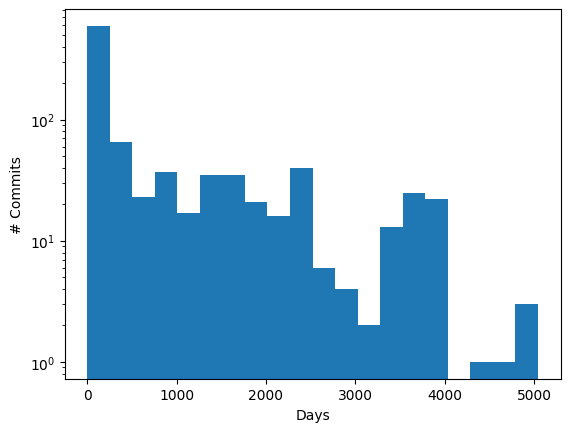

In [8]:
df_pos['days']=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

df1=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

 

df2=df1.to_frame()

 

le.save('FIXBELOWHANDREDDAYS', len(df2[(df2['commit_tag_delay']).round()<100]), 'Number of fix commits released in less than 100 days')

le.save('FIXBELOWONEDAYS', (len(df2[(df2['commit_tag_delay']).round() <1 ]) ), 'Number of fix commits released in less than 1 days')

le.save('FIXNOTRELEASED', len(df_pos[df_pos['days']==np.nan]), 'Number of fix commits not released')

 

d = {'Days': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,500,1000,2000 ],
     '# Commits': [len(df2[df2['commit_tag_delay'].round()<1]),
        len(df2[df2['commit_tag_delay'].round()>=1])&len(df2[df2['commit_tag_delay'].round()<2]),
        len(df2[df2['commit_tag_delay'].round()>=2])&len(df2[df2['commit_tag_delay'].round()<3]),
        len(df2[df2['commit_tag_delay'].round()>=3])&len(df2[df2['commit_tag_delay'].round()<4]),
        len(df2[df2['commit_tag_delay'].round()>=4])&len(df2[df2['commit_tag_delay'].round()<5]),
        len(df2[df2['commit_tag_delay'].round()>=5])&len(df2[df2['commit_tag_delay'].round()<6]),
        len(df2[df2['commit_tag_delay'].round()>=6])&len(df2[df2['commit_tag_delay'].round()<7]),
        len(df2[df2['commit_tag_delay'].round()>=7])&len(df2[df2['commit_tag_delay'].round()<8]),
        len(df2[df2['commit_tag_delay'].round()>=8])&len(df2[df2['commit_tag_delay'].round()<9]),
        len(df2[df2['commit_tag_delay'].round()>=9])&len(df2[df2['commit_tag_delay'].round()<10]),
        len(df2[df2['commit_tag_delay'].round()>=10])&len(df2[df2['commit_tag_delay'].round()<11]),
        len(df2[df2['commit_tag_delay'].round()>=11])&len(df2[df2['commit_tag_delay'].round()<12]),
        len(df2[df2['commit_tag_delay'].round()>=12])&len(df2[df2['commit_tag_delay'].round()<13]),
        len(df2[df2['commit_tag_delay'].round()>=13])&len(df2[df2['commit_tag_delay'].round()<14]),
        len(df2[df2['commit_tag_delay'].round()>=14])&len(df2[df2['commit_tag_delay'].round()<15]),
        len(df2[df2['commit_tag_delay'].round()>=15])&len(df2[df2['commit_tag_delay'].round()<50]),
        len(df2[df2['commit_tag_delay'].round()>=50])&len(df2[df2['commit_tag_delay'].round()<100]),
        len(df2[df2['commit_tag_delay'].round()>=100])&len(df2[df2['commit_tag_delay'].round()<500]),
        len(df2[df2['commit_tag_delay'].round()>=500])&len(df2[df2['commit_tag_delay'].round()<1000]),
        len(df2[df2['commit_tag_delay'].round()>=1000])&len(df2[df2['commit_tag_delay'].round()<2000])
]}

df = pd.DataFrame(data=d)

   

with open('msr2019/tex/delays'+'.tex','w') as tf:

        tf.write(df.to_latex(columns=['Days','# Commits'],index=False, column_format='lc'))

   

 

plt.savefig('msr2019/img/commitTagDelay'+'.pdf', dpi=200, bbox_inches='tight')
matplotlib.pyplot.hist(df1.round(),bins=20,log=True,histtype='bar')
matplotlib.pyplot.xlabel("Days")
matplotlib.pyplot.ylabel("# Commits")

## Create deduplicated version of (pos) dataset

Deduplication is based on the equality of commit messages.

In [ ]:
# count duplicates

dup_idx = df_pos.duplicated(subset='msg')
if(len(dup_idx.value_counts())>1):
    dup_commit_count = dup_idx.value_counts()[1]
print('There are {} duplicate commits out of {}'.format(dup_commit_count, len(df_pos.index)))

le.save('DUPLICATECOMMITSCOUNT', dup_commit_count, 'Number of duplicate commits')

In [ ]:
df_pos_dedup = df_pos.drop_duplicates(subset='msg')
df_pos[df_pos.duplicated(subset='msg')].vuln_id.nunique()
# df_pos_dedup.vuln_id.nunique()
df_pos[dup_idx].sort_values('msg')

In [ ]:
le.save('DATASETSIZEPOS', len(df_pos.index), 'Number of \'pos\' commits in the dataset (this includes duplicates!)' )
le.save('DATASETSIZEPOSDEDUP', len(df_pos_dedup), 'Number of pos commits, **de-duplicated**')
# le.print()

## Expand dataset with 'negative' instances

In [ ]:
# import pandas as pd
# from acacia.git import *
# # from acacia.dataset import *
# from tqdm import tqdm



def expand_dataset(repos_set, df_pos):
    neg_instances = []
    SEC_REGEXP = '(denial.of.service|XXE|remote.code.execution|open.redirect|osvdb|secur.+|vuln.+|exploit.+|malicious.*|attack.*|dos|directory.traversal|injection|cve-\d+-\d+|xss|nvd|cross.site|csrf|rce|clickjack|session.fixation|advisory|insecur.+|cross.origin|unauthori[z|s].+)'

    for repo in tqdm(repos_set):
        count = len(df_pos.loc[df_pos['repo_url'] == repo])
        commits = get_random_commits(int(count * RATIO_POS_NEG), repo, GIT_REPO_FOLDER)
        for c in commits:
            try:
                new_instance = {}
                commit_msg = extract_commit_msg(c, repo, GIT_REPO_FOLDER)
                commit_diff = extract_commit_diff(c, repo, GIT_REPO_FOLDER) 
                if re.match(SEC_REGEXP, commit_msg.decode("utf-8")):
                    print('Found match of SEC_REGEXP in NEG instance')
                    print(commit_msg)

                new_instance = {
                    'msg' : commit_msg.decode("latin-1") ,
                    'diff': commit_diff.decode("latin-1") ,
                    'cls': 'neg',
                    'commit_id': c,
                    'repo_url': repo ,
                    'vuln_id' : '',
                    'in_nvd': False,
                    'fix_tag': '',
                    'fix_tag_timestamp': 0,
                    'commit_timestamp' : 0,
                    'commit_tag_delay': 0
                }
                neg_instances.append(new_instance)
            except Exception as e:
                print('There was an exception with this commit, skipping: %s:%s' % (repo,c) )
                print(e)
    return pd.DataFrame(neg_instances)

df_neg = expand_dataset(repos_set,df_pos_dedup)


In [ ]:
df_all = pd.concat([df_pos_dedup, df_neg], ignore_index = True, sort=False)
overall_size = len(df_all.index)
print('The dataset contains '+ str(overall_size) + ' commits')

## Persist dataset

### Pickle

In [ ]:
df_all.to_pickle(DATASET_NAME + '_all.pd')
df_pos.to_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup.to_pickle(DATASET_NAME + '_pos_dedup.pd')

### CSV

In [ ]:
df_all[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '.csv')
df_pos_dedup[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos_dedup.csv')
df_pos[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos.csv')

# Analysis

In [ ]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup = pd.read_pickle(DATASET_NAME + '_pos_dedup.pd')

In [ ]:
 def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

le.save('VULNLOSSDEDUP',
            len(diff(set(df_pos['vuln_id'].values),set(df_pos_dedup['vuln_id'].values))),
            'Number of vulnerabilities removed by the deduplication as they have the same fix commits than other vulnerabilities ')


In [ ]:
def print_counts(df, suffix=''):
    print("Dataset size:           {}".format(len(df.index)))
    print("Instances of class POS: {}".format(len(df[df['cls'] == POS_CLS ])))
    print("Instances of class NEG: {}".format(len(df[df['cls'] == NEG_CLS ])))

    le.save('COMMITCOUNT' + suffix,
            len(df[df['cls'] == POS_CLS ]),
            'Number of commits ' + suffix)
    
    le.save('VULNCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].vuln_id.nunique(),
            'Unique vulnerabilities (after mapping vulns) ' + suffix)

    le.save('REPOCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].repo_url.nunique(),
            'Number of unique repositories (after removing internal, dead, svn). ' + suffix)
    
    df.head()

print_counts(df_pos)
print('-----------------------------------------------')
print_counts(df_pos_dedup,'DEDUP')



### Number of Commits per CVE

In [ ]:
def printVulnXCommit(df,suffix=''):
    df2 = df.loc[df['cls']==POS_CLS,['commit_id','vuln_id']]
    df_vulnOnly = df2[['vuln_id']]
    df_vulnOnly['commits'] = df_vulnOnly.groupby('vuln_id')['vuln_id'].transform('count')
    df_vulnOnly=df_vulnOnly.drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='commits',ascending=False)
    #print(df_vulnOnly.sort_values(by='commits',ascending=False).head(20))
    print("Number of vuln with 1 commit {}: {}".format(suffix, len(df_vulnOnly[df_vulnOnly['commits']==1])))


    with open('msr2019/tex/commitXvuln'+suffix+'.tex','w') as tf:
        tf.write(df_vulnOnly.to_latex(columns=['vuln_id','commits'],index=False, column_format='lc'))
        
    # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)

    df_vulnOnly.groupby('commits').count().plot(ax=ax1, kind='bar',logy=True )

    labels = df_vulnOnly.groupby('commits').count()
#     print(labels['vuln_id'].tolist())
    #for i, v in enumerate(labels['vuln_id'].tolist()):
    #    ax1.text(v , i + .25, str(v), color='blue', fontweight='bold')
    
    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    # plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Vulnerabilities', x=0.52, y=0.85)
    plt.ylabel('# Vulnerabilities')
    plt.xlabel('# Commits')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.savefig('msr2019/img/commitXvuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printVulnXCommit(df_pos)
print('-----------------------------------------------')
printVulnXCommit(df_pos_dedup,'DEDUP')
        

### Number of vulnerabilities per repository

In [ ]:
def printvulnXrepo(df,suffix=''):
    df1=df.loc[df['cls']==POS_CLS,['repo_url','vuln_id']]

    #df1.groupby('repo_url').vuln_id.nunique()
    df1['distinct_vuln']=df1.groupby('repo_url')['vuln_id'].transform('nunique')
    df1.sort_values(by=['repo_url','vuln_id'])



    df1=df1[['repo_url','distinct_vuln']].drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='distinct_vuln',ascending=False)
    #df1.plot()
    #df1.groupby('distinct_vuln').count().plot(kind='bar')

    with open('msr2019/tex/vulnXrepo'+suffix+'.tex','w') as tf:
        tf.write(df1.to_latex(columns=['repo_url','distinct_vuln'],index=False, column_format='lc'))
        # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)
    #print(df1.groupby('distinct_vuln').count())
    df1.groupby('distinct_vuln').count().plot(ax=ax1, kind='bar',logy=True )

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Repositories')
    plt.xlabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/repoXNumVuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printvulnXrepo(df_pos)
printvulnXrepo(df_pos_dedup,'DEDUP')


### Vulnerabilities per year

In [ ]:
def getYear(vuln_id):
    LOOKUP_TABLE_YEAR = {
        "413684" : "2013",
        "SONARQUBE-001" : "2018",
        "NIFI-4436" : "2017",
        "HADOOP-14246" : "2017",
        "HDFS-10276" : "2016",
        "ND4J-001" : "2018",
        "APACHE-COMMONS-001" : "2018",
        "HADOOP-13105" : "2016",
        "HADOOP-12001" : "2015",
        "HADOOP-15212" : "2018",
        "APACHE-AXIS2-5683" : "2015",
        "S2-028" : "2017",
        "PLEXUS-ARCHIVER-87" : "2018",
        "HADOOP-12751" : "2016",
        "JAVAMELODY-252" : "2015",
        "PT-2013-65" : "2013",
        "SPR-7779" : "2010",
        "HTTPCLIENT-1803" : "2017",
        "PRIMEFACES-1194" : "2016",
        "JAVAMELODY-631" : "2017",
        "ZEPPELIN-2769" : "2017",
        "APACHE-AXIS2-5846" : "2017",
        "AMQ-5751" : "2015",
        "AMQP-590": "2016",
        "2012-05-05" : "2012",
        "HUDSON-483532" : "2015",
        "GEODE-4270" : "2018",
        "S2-043" : "2016",
        "JETTY-1042" : "2009",
        "COLLECTIONS-580": '2015',
        "PDFBOX-3341":"2016"
    }
    z = re.search(r'(?<=CVE-)\d{4}',vuln_id)
    if(z is not None):
        year = z.group(0)
    else:
        year = LOOKUP_TABLE_YEAR[vuln_id]
    return year

def checkNVD(vuln_id):
    url = 'https://nvd.nist.gov/vuln/detail/'+vuln_id
#     print('Checking the NVD for ' + url)
    r = requests.get('https://nvd.nist.gov/vuln/detail/'+vuln_id)
    if r.status_code!=200 :
        return False
    if 'CVE ID Not Found' in r.text:
        return False
    if 'Vuln ID, expected format: CVE-'  in r.text:
        return False
    return True
        

In [ ]:
def printVulnXYear(df,suffix=''):
    df_vuln=df.loc[df['cls']==POS_CLS,['vuln_id']].drop_duplicates(subset=None, keep='first', inplace=False)

    print("Number of distinct vuln {} : {}".format(suffix, len(df_vuln)))

    df_vuln['year'] = df_vuln['vuln_id'].apply(lambda x: getYear(x))

    # Create figure
    f, ax1 = plt.subplots(figsize=(5,4), dpi=200)

    df_vuln.groupby('year').count().plot(kind='bar',ax=ax1)

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/vulnXYear'+suffix+'.pdf', dpi=200, bbox_inches='tight')
    
printVulnXYear(df_pos)
printVulnXYear(df_pos_dedup,'DEDUP')

In [ ]:
def populateInNvd(df):
    count=0
    for i, row in df.iterrows():
        #print('https://nvd.nist.gov/vuln/detail/'+x)
        count += 1
        print('.', end = '')
        if not count % 50:
            print(' ' + str(count) + '\n')
        check_outcome = checkNVD(df.at[i,'vuln_id'])
        df.at[i,'in_nvd'] = check_outcome
    print('\n')
        
populateInNvd(df_pos)
populateInNvd(df_pos_dedup)

In [ ]:
def countNVDStats(df,suffix=''):
    vulns_all_count = df.vuln_id.nunique()
    le.save('ALLVULNSCOUNT' +suffix,
            vulns_all_count,
            "Number of distinct vulnerabilities in the dataset " + suffix)

    vulns_nvd_count = df[df['in_nvd'] == 1.0 ].vuln_id.nunique()
    le.save('ALLVULNSINNVD'+suffix,
        vulns_nvd_count,
        'Number of vulnerabilities found in the NVD '  + suffix)

    cves_no_nvd_count = vulns_all_count - vulns_nvd_count
    le.save('CVENONVD'+suffix,
        cves_no_nvd_count,
        'Number of vulnerabilities that have a CVE but are not found in the NVD '  + suffix)

    cves_count = len(df[df['vuln_id'].str.contains('CVE-')]['vuln_id'].unique())
    le.save('VULNSNOCVE'+suffix,
        vulns_all_count - cves_count,
        'Number of vulnerabilities that do not have a CVE name '  + suffix)
    
countNVDStats(df_pos)
countNVDStats(df_pos_dedup,'DEDUP')